In [26]:
%matplotlib inline 

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import jax
import jax_cosmo as jc

import pyccl as ccl

In [32]:
# CCL 
cosmo_ccl = ccl.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, n_s=0.96, sigma8=0.8,
        Neff=0, transfer_function="eisenstein_hu", matter_power_spectrum="halofit")

# Jax-cosmo
cosmo_jax = jc.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, sigma8 = 0.8, n_s=0.96,
         Omega_k=0., w0=-1., wa=0.)

c = jc.constants.c

In [124]:
# Smail Parameters 
n_smail = 1.78e4 
a_smail = 1.64e0
b_smail = 3.73e0
z0_smail = 4.10e-1

zvec = np.arange(0.0, 0.5, 0.001)
avec = 1/(1+zvec)

nzvec = jc.redshift.smail_nz(a_smail, b_smail, z0_smail)

ellvec = np.linspace(0, 500, 101).astype(int)
ellvec[0] = 1

kvec = np.logspace(-4.0, np.log10(4.0), 2000)

bias = jc.bias.constant_linear_bias(1.0)
tracer_galaxy_clustering = jc.probes.NumberCounts([nzvec], bias) 


### Limber

In [101]:
cl_limber = jc.angular_cl.angular_cl(cosmo_jax, ellvec, [tracer_galaxy_clustering])

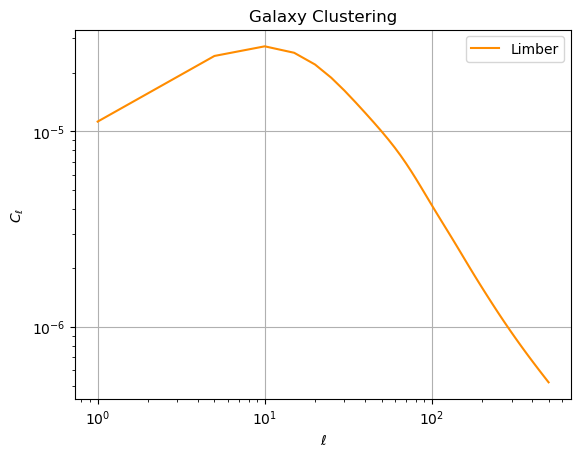

In [102]:
plt.plot(ellvec, cl_limber[0], color='darkorange' ,label='Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

### Non-Limber

In [130]:
def galaxy_clustering_kernel_integrand(chi, ell, k, dndz):
    
    j = sp.special.spherical_jn(ell, np.outer(k, chi), derivative=False)  # Spherical Bessel Function 
    window = sp.interpolate.splev(chi, dndz, ext=0)

    return window * j 

def cell_integrand(k, window1, window2):
    
    #pk = jc.power.nonlinear_matter_power(cosmo_jax, k, 1.0)
    pk = ccl.nonlin_matter_power(cosmo_ccl, k*cosmo_jax.h, 1.0)*cosmo_jax.h**3
    window1 = sp.interpolate.splev(k, window1, ext=0)
    window2 = sp.interpolate.splev(k, window2, ext=0)

    return pk * window1 * window2

def galaxy_clustering_non_limber_cl(chi, window_chi, kvec, ellvec, output_file_path):
    
    cl_gg = np.zeros(len(ellvec))

    for i, ell in enumerate(ellvec):
        galaxy_clustering_kernel = np.zeros(len(kvec))
        
        for k, kval in enumerate(kvec):
            galaxy_clustering_kernel[k] = sp.integrate.quad(galaxy_clustering_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        
        galaxy_clustering_spline = sp.interpolate.splrep(kvec, kvec*galaxy_clustering_kernel)

        cl_gg[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, kvec[0], kvec[-1], args=(galaxy_clustering_spline, galaxy_clustering_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        print(ell, cl_gg[i])
        #break 

    np.savetxt(output_file_path, cl_gg, fmt="%g", header="Cl_gg")

    return cl_gg

In [131]:
file_path = '/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_gg.csv'

chi = jc.background.radial_comoving_distance(cosmo_jax, avec)

#window_gg_z = tracer_galaxy_clustering.kernel(cosmo_jax, zvec, ellvec)[0]

window_gg_chi = sp.interpolate.splrep(chi, nzvec(zvec) * jc.background.growth_factor(cosmo_jax, avec) * jc.background.H(cosmo_jax, avec) / c / (zvec[1] - zvec[0]) / np.sum(nzvec(zvec))) 

In [132]:
cl_non_limber = galaxy_clustering_non_limber_cl(chi, window_gg_chi, kvec, ellvec, file_path)

/var/folders/nc/q08wj91x3_94kqtckryqhfxh0000gn/T/ipykernel_49543/1379939827.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  galaxy_clustering_kernel[k] = sp.integrate.quad(galaxy_clustering_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]


1 1.6099277122519224e-05
5 2.8542038048888176e-05
10 3.1256878527248366e-05


/var/folders/nc/q08wj91x3_94kqtckryqhfxh0000gn/T/ipykernel_49543/1379939827.py:25: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  galaxy_clustering_kernel[k] = sp.integrate.quad(galaxy_clustering_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
/var/folders/nc/q08wj91x3_94kqtckryqhfxh0000gn/T/ipykernel_49543/1379939827.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cl_gg[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, kvec[0], kvec[-1], args=(galaxy_clustering_spline, galaxy_clustering_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]


15 2.8857470061974196e-05
20 2.497597239198199e-05
25 2.13348110640999e-05
30 1.831112852202899e-05
35 1.5929677658812687e-05
40 1.4067702161753543e-05
45 1.2582720983199294e-05
50 1.1358294511534674e-05
55 1.0312795975051307e-05
60 9.39458208080971e-06
65 8.573772040367113e-06
70 7.834638362242693e-06
75 7.169587585982698e-06
80 6.574642045618835e-06
85 6.046513782420337e-06
90 5.581095481204857e-06
95 5.173042008827238e-06
100 4.816055764967539e-06
105 4.503358380261547e-06
110 4.228151743833859e-06
115 3.984044671348337e-06
120 3.7653939329176268e-06
125 3.5675526746552816e-06
130 3.3869622093555035e-06
135 3.221033818846174e-06
140 3.0680262279226625e-06
145 2.9262833281324856e-06
150 2.795028542742892e-06
155 2.673297875348038e-06
160 2.5604346203849116e-06
165 2.4559578964190315e-06
170 2.3594093607236244e-06
175 2.2702469042092203e-06
180 2.187806165288783e-06
185 2.111373840996746e-06
190 2.040284144182831e-06
195 1.973962039379969e-06
200 1.9119149738784446e-06
205 1.853709360

In [136]:
cl_non_limber = pd.read_csv('/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_gg.csv')
cl_non_limber = cl_non_limber['# Cl_gg'].values

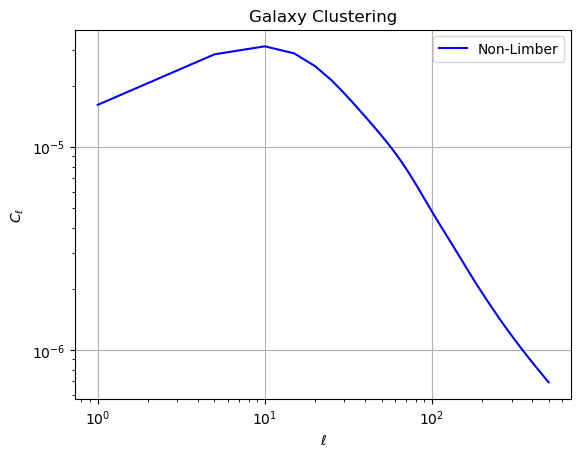

In [138]:
plt.plot(ellvec, cl_non_limber, color='blue', label='Non-Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

### Comparison

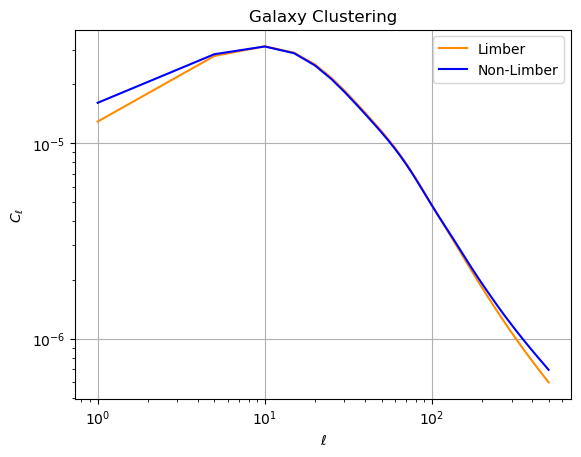

In [186]:
plt.plot(ellvec, cl_limber[0]*1.15, color='darkorange' ,label='Limber')
plt.plot(ellvec, cl_non_limber, color='blue', label='Non-Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

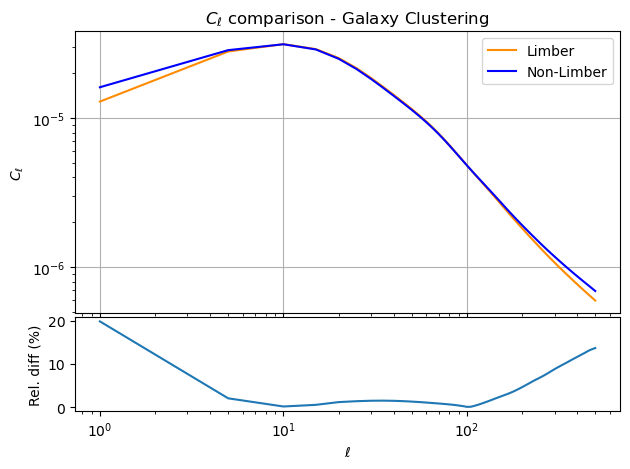

In [187]:
# Relative difference

factor = 1.15

rel_diff = (np.abs(cl_limber*factor - cl_non_limber) / cl_non_limber) * 100

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
a0.set_title("$C_{\ell}$ comparison - Galaxy Clustering")
a0.plot(ellvec, cl_limber[0]*factor, ls='-', label='Limber', color = 'darkorange')
a0.plot(ellvec, cl_non_limber, ls='-', label = 'Non-Limber', color='blue')
a0.grid()
a0.set_yscale("log")
a0.set_xscale("log")
a0.set_ylabel("$C_{\ell}$")
a0.legend()
a1.plot(ellvec, rel_diff[0])
a1.set_xlabel("$\ell$")
a1.set_ylabel("Rel. diff (%)")
#a1.set_xlim(0.18, 0.5)
#a1.set_yscale("log")
f.tight_layout()
plt.subplots_adjust(hspace=0.02)